# Confusion plots

Copyright (c) 2020-2021 Herman Kamper, MIT License.

## Preliminaries

In [1]:
%matplotlib inline
from pathlib import Path
from sklearn.cluster import SpectralCoclustering
from tqdm import tqdm
import numpy as np
import seaborn as sns
import pandas as pd
import pylab as plt
import sys

sys.path.append("..")

from eval_segmentation import boundaries_to_intervals, intervals_to_boundaries, get_intervals_from_dir
from phoneseg_algorithms import get_segment_intervals, l2_segmentation, l2_n_segments, benji_l2_n_segments

In [2]:
# Dataset
dataset = "buckeye"
split = "val"
model = "vqvae"
phoneseg_tag = "phoneseg_l2"
# phoneseg_tag = "phoneseg_l2.4"

# Directories
indices_dir = Path("../exp/")/model/dataset/split/"indices"
z_dir = Path("../exp/")/model/dataset/split/"auxiliary_embedding2"
phoneseg_dir = Path("../exp/")/model/dataset/split/phoneseg_tag/"intervals"
phoneref_dir = Path("../data/")/dataset/"phone_intervals"
audio_dir = Path("../../VectorQuantizedCPC/datasets/")/dataset/split

## Read segmentation and reference

In [3]:
# Read segmentation
segmentation_interval_dict = {}
segmentation_interval_dict = get_intervals_from_dir(phoneseg_dir)
utterances = segmentation_interval_dict.keys()

# Read phone reference
phone_ref_interval_dict = get_intervals_from_dir(phoneref_dir, utterances)

100%|██████████| 16512/16512 [00:00<00:00, 27742.87it/s]


## Overlap

In [154]:
# Get overlap
overlap_dict = {}  # overlap["307"]["dh"] is frames of code 307 overlapping with "dh"
phones = set()
for utt_key in tqdm(phone_ref_interval_dict):
    for interval_left, interval_right, code_index in segmentation_interval_dict[utt_key]:
        code_index = int(code_index)
        if code_index not in overlap_dict:
            overlap_dict[code_index] = {}
        for gt_left, gt_right, phone in phone_ref_interval_dict[utt_key]:
            phones.add(phone)
            if gt_right <= interval_left or gt_left >= interval_right:
                continue
            overlap = interval_right - interval_left
            if gt_left > interval_left:
                overlap -= gt_left - interval_left
            if gt_right < interval_right:
                overlap -= interval_right - gt_right
            if phone not in overlap_dict[code_index]:
                overlap_dict[code_index][phone] = 0
            overlap_dict[code_index][phone] += overlap

100%|██████████| 16339/16339 [00:00<00:00, 22600.22it/s]


In [155]:
# Counts
code_indices = sorted([code_index for code_index in overlap_dict])
phones = sorted(phones)
counts = np.zeros((len(code_indices), len(phones)))
for i_code, code_index in enumerate(code_indices):
    for i_phone, phone in enumerate(phones):
        if phone in overlap_dict[code_index]:
            counts[i_code, i_phone] = overlap_dict[code_index][phone]
            
# Normalize counts to get P(phone|code)
confusion_matrix = counts.T
confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=0, keepdims=True)

In [156]:
# Cluster
df = pd.DataFrame(confusion_matrix, index=phones, columns=range(confusion_matrix.shape[-1]))
model = SpectralCoclustering(n_clusters=20, random_state=0, svd_method="arpack", n_init=50)
model.fit(df.values)

# Reindex dataframe so that clustered phones are adjacent to eachother
df2 = df.reindex(index=[df.index[i] for i in np.argsort(model.row_labels_)], columns=[df.columns[i] for i in np.argsort(model.column_labels_)])

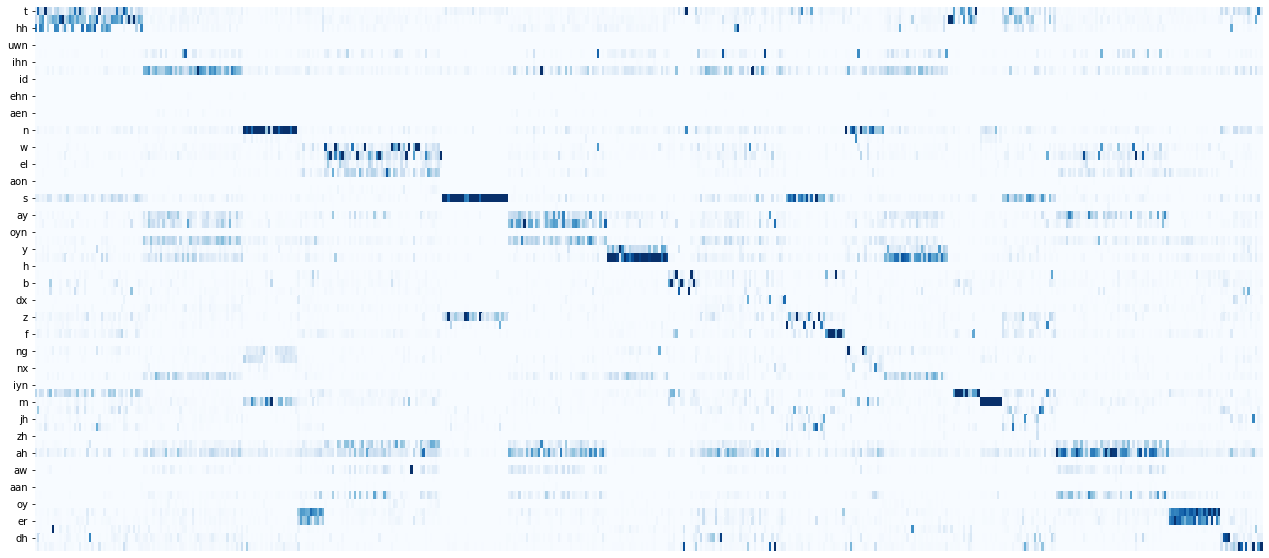

In [206]:
# Plot
plt.figure(figsize=(22, 10))
sns.heatmap(df2, vmin=0, vmax=0.5, cbar=False, cmap="Blues", xticklabels=[])

In [207]:
# Total number of frames
print("Total no. frames: {:d}".format(int(np.sum(counts))))

# Remove low count phones and codes
drop_phones = []
drop_codes = []
for i_phone, phone in enumerate(phones):
    n_frames = np.sum(counts[:, i_phone])
    if n_frames < 500:
        drop_phones.append(phone)
#         print("Dropping:", phone)
for i_code, code_index in enumerate(code_indices):
    n_frames = np.sum(counts[i_code, :])
    if n_frames < 100:
        drop_codes.append(i_code)
#         print("Dropping:", code_index)
df3 = df.drop(drop_phones)
df3 = df3.drop(columns=drop_codes)

# Cluster
model3 = SpectralCoclustering(n_clusters=20, random_state=0, svd_method="arpack", n_init=50)
model3.fit(df3.values)

# Reindex dataframe so that clustered phones are adjacent to eachother
df4 = df3.reindex(index=[df3.index[i] for i in np.argsort(model3.row_labels_)], columns=[df3.columns[i] for i in np.argsort(model3.column_labels_)])

Total no. frames: 1219356


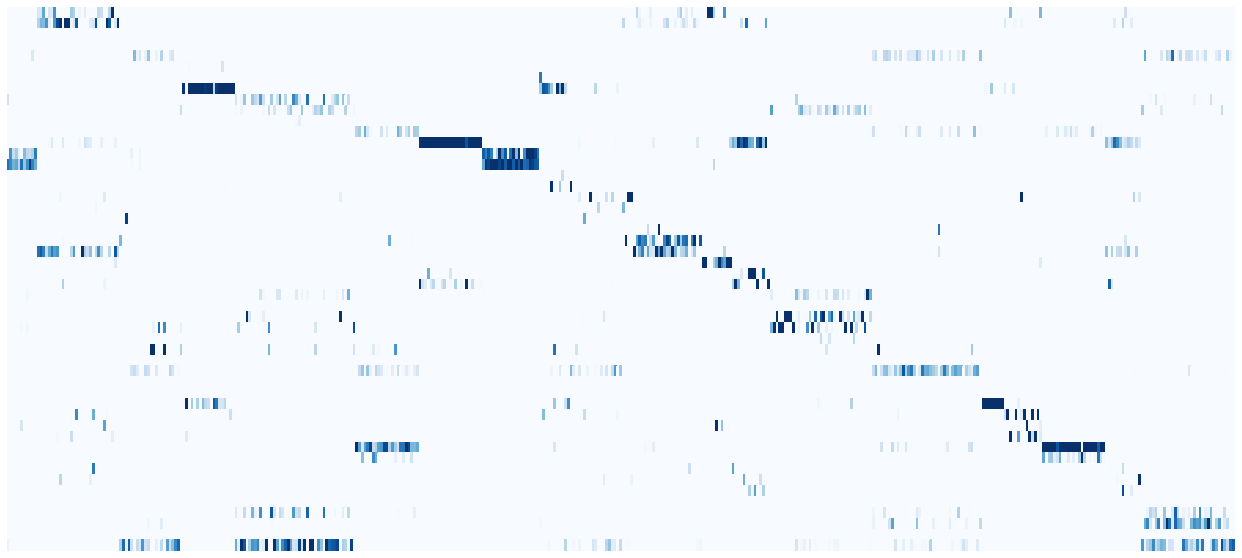

In [208]:
# Plot
plt.figure(figsize=(22, 10))
sns.heatmap(df4, vmin=0.1, vmax=0.4, cbar=False, cmap="Blues", xticklabels=[], yticklabels=[])